# Days to Publication
In this example, we'll use webscraping techniques to collect data on the average number of days to publication (from manuscript reception to online publication) from scientific journals.  Once we have the data, we will use a simple linear regression model to try to predict the average number of days to publication from a few basic predictors.

### Import libraries

In [499]:
#For RSS feed parsing/webscraping
import feedparser
import urllib2
from bs4 import BeautifulSoup
import re
from selenium import webdriver #for website that require javascript, ie a web browser
from selenium.webdriver.remote.errorhandler import SessionNotCreatedException

#For data cleaning and visualization
import os
import dateutil.parser as dparser
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import unicodedata
pd.options.display.max_colwidth = 100

### Define filter_size
Define a helper function that will filter out longer text entries; when we are searching for "Published" and "Received" strings, we want to make sure we don't include any instances of these words in abstracts or other long bodies of text

In [3]:
def filter_size(l,size):
    return [item for item in l if len(item)<size]

### Define feed collectors
This is how we mass collect RSS feeds to search through.  Most publishers will have a home web page with links to the RSS feeds of all their journals. We will need to define a separate feed collector function for every publisher (in our case: ACS, RSC & APS) because the html structure differs for each publisher site. 
Alternatively, one could manually specify specific RSS feeds to check out by adding to the feeds dictionary by hand.
 
For each collector function, we pass in a dictionary whose keys are publishers. We create a new entry (a dictionary) for the present publisher. We then populate this dictionary with journal names as keys and links to the journal's RSS feed as values.

In [10]:
#Collect all RSS feeds from home web page of publisher: RSC
def rsc_collect(feeds):
    feeds['RSC']={}
    driver.get('http://pubs.rsc.org/en/ealerts/rssfeed') 
    html = driver.page_source
    soup = BeautifulSoup(html,'lxml')
    links = soup.find_all(attrs={"class": "rss_text"})
    for l in links:
        journal = l.a.string.replace(' ','')
        print journal, l.a['href']
        feeds['RSC'][journal]=feedparser.parse(l.a['href'])
    return

In [14]:
#Collect all RSS feeds from home web page of publisher: ACS
def acs_collect(feeds):
    feeds['ACS']={}
    driver.get('https://pubs.acs.org/page/follow.html#1c4fed33-6556-443d-ad77-2af8bd5227fb-b6de7b7c-de82-45a5-9538-313dd15c6659') #for website that require javascript/a web browser
    html = driver.page_source
    soup = BeautifulSoup(html,'lxml')
    feed_streams = soup.find_all(attrs={"class": "feeds"})
    for feed in feed_streams:
        for link in feed:
            #journals all start with '<'
            if str(link).startswith('<'):
                journal = link.a.string.replace(' ','')
                #remove cenNews & analyticalchemNews
                if 'News' in journal:
                    continue
                #Remove RSS feeds by topic; only include those by journal
                if link.a['href'].startswith('/topic'):
                    continue
                    
                print journal, link.a['href']
                feeds['ACS'][journal]=feedparser.parse(link.a['href'])
    return

In [7]:
#Collect all RSS feeds from home web page of publisher: APS
def aps_collect(feeds):
    feeds['APS']={}
    driver.get('https://journals.aps.org/feeds')
    html = driver.page_source
    soup = BeautifulSoup(html,'lxml')
    links = soup.find_all('h3')

    for l in links:
        if l.a and '/rss' in l.a['href']:
            if str(l).startswith('<h3>Physical') or str(l).startswith('<h3>Reviews'):
                journal =  l.text.strip()
                print journal
                print l.a['href']
                feeds['APS'][journal]=feedparser.parse(l.a['href'])
    return

### Collect RSS feeds
Now, we will run our RSS feed collector functions.
To access sites that require javascripts (which is most of those we're considering), we can't just read the raw source code of the websites.  Instead, we have to open a new session of an automated browser window to read the sites.  I am using Safari, but the below commands can be reconfigured for another browser.  If using Safari, ensure that you have checked the "Allow remote automation" option in the "Develop" click-down Safari menu. 
A finnicky aspect of this approach is that an error will be thrown if an automated session is already running.  To remedy this, we use a try/except block to catch the `SessionNotCreatedException`. 

In [58]:
#Launch webdriver, may need to run twice to get rid of webdriver error
try:
    driver= webdriver.Safari()
except SessionNotCreatedException:
    pass

#Collect desired RSS feeds
feeds = {}
rsc_collect(feeds)
acs_collect(feeds)
#Unfortunately, APS flags automation and blocks IP address.  Won't include them for now.
#aps_collect(feeds)


Analyst http://feeds.rsc.org/rss/an

AnalyticalMethods http://feeds.rsc.org/rss/ay

BiomaterialsScience http://feeds.rsc.org/rss/bm

CatalysisScience&Technology http://feeds.rsc.org/rss/cy

ChemicalCommunications http://feeds.rsc.org/rss/cc

ChemicalScience http://feeds.rsc.org/rss/sc

ChemicalSocietyReviews http://feeds.rsc.org/rss/cs

ChemistryEducationResearchandPractice http://feeds.rsc.org/rss/rp

CrystEngComm http://feeds.rsc.org/rss/ce

DaltonTransactions http://feeds.rsc.org/rss/dt

Energy&EnvironmentalScience http://feeds.rsc.org/rss/ee

EnvironmentalScience:Nano http://feeds.rsc.org/rss/en

EnvironmentalScience:Processes&Impacts http://feeds.rsc.org/rss/em

EnvironmentalScience:WaterResearch&Technology http://feeds.rsc.org/rss/ew

FaradayDiscussions http://feeds.rsc.org/rss/fd

Food&Function http://feeds.rsc.org/rss/fo

GreenChemistry http://feeds.rsc.org/rss/gc

InorganicChemistryFrontiers http://feeds.rsc.org/rss/qi

IntegrativeBiology http://feeds.rsc.org/rss/ib

Journalo

### Prepare the dataframe
Now we need to get a dataframe ready to store all the data we will collect.  If you're starting from scratch, you can use the first command to create an empty dataframe with the necessary columns.  Or you can upload the pickle file provided.

In [203]:
#Create empty df template
#df = pd.DataFrame(columns=['Link','Title','Publisher','Journal','Authors','RDate','PDate'])

#Or import df from pkl file
df = pd.read_pickle('all-RSS.pkl')

### Collect article information
Ok! Now we are ready to collect article information and begin to populate our dataframe.  We will grab information like the title of the article, the authors, the received date and the date published online.

<font color=red>Warning! If you are on a network where you have read-access to the articles, your IP address will be flagged and you will lose access.</font>
Even though we are not mass downloading any article pdfs, the activity will resemble that, so the publishers will prevent you from accessing their website any more.  (APS does this even when you are not on a network that can access their articles).  For example, if you are a university student and you are on the university network, this may be the case.  To check whether you are on an accessible network, go to a couple of the article homepages manually and see if you can download the article pdf for free, or if you need to login/pay.  If you see you need to login/pay, then go ahead and continue!  Otherwise, wait until you are off of this network to proceed.

Another thing to note, is that this approach will only give us access to the articles still listed on a journal's RSS feed (ie they will be fairly recent articles).  Unfortunately, there is no easy way that I have found to automate the collection of this data from a longer timeframe.  

Final note: this will take some time! Good time to grab a coffee or take a lunch break.

In [47]:
#Launch webdriver, may need to run twice to get rid of webdriver error
try:
    driver= webdriver.Safari()
except SessionNotCreatedException:
    pass

#Collect data!
for publisher in feeds:
    for feed in feeds[publisher]:
        for art in feeds[publisher][feed].entries:
            Title = art.title
            Link =  art.id
            print feed
            print Title, Link
            
            #check if article already in df
            if Link in df['Link'].values:
                print "Skipped: ",Link
                continue
            
            Authors = []
            try:
                for auth in art.authors:
                    Authors.append(auth['name'])
            except:
                Authors = None
            print Authors
            
            Publisher = publisher
            Journal=feed

            #urllib2.urlopen(art.link) #can be used only with non javascript sites
            driver.get(art.link) #for website that require javascript/a web browser
            html = driver.page_source
            soup = BeautifulSoup(html,'lxml')

            #find all instances mentioning published or received
            pub1 = soup.body.findAll(text=re.compile('[P,p]ublished \d{1,2}'),limit=3)
            pub2 = soup.body.findAll(text=re.compile('[P,p]ublished on'),limit=3)
            rec = soup.body.findAll(text=re.compile('[R,r]eceived '), limit=3)

            #remove longer instances, ie abstracts
            pub1 = filter_size(pub1,200)
            pub2 = filter_size(pub2,200)            
            rec = filter_size(rec,200)

            if len(pub1)>len(pub2):
                pub = pub1
            else:
                pub = pub2    
                
            #skip if more than one instance found of pub or rec
            if len(pub)!=1 or len(rec)!=1:
                print "Warning, missing or ambiguous rec/pub string instances; skipping"
                continue

            #Remove duplicate date entries (ie rec and pub mentioned in same string), may not matter
            if pub == rec:
                rec = [] 

            #For aps
            pub[0] = unicodedata.normalize('NFKD', pub[0]).encode('ascii','ignore')

            #Just skip entry if this step gives any problems
            try: 
                pubrec = str(' '.join(pub+rec).replace('\n',' '))
            except UnicodeEncodeError:
                print "Skipping: unable to parse unicode"
                continue
            
            print pubrec
            matches = re.findall(r'\d{1,2} [a-zA-Z]{3,8} \d{4}', pubrec)

            #Set so no duplicate dates added
            dates = set()
            RDate = None
            PDate = None
            for match in matches:
                date = dparser.parse(match,fuzzy=True)
                dates.add(date)

            #Assign published and received dates based on time sequence
            dates = list(dates)
            dates.sort()
            if len(dates)>=2:
                RDate =dates[0]
                PDate = dates[-1]

            #Append new data to df
            print "saving to DF:",Link
            df = df.append({'Authors':Authors,
                      'Journal':Journal,
                      'Link':Link,
                       'PDate':PDate,
                       'RDate':RDate,
                       'Publisher':Publisher,
                       'Title':Title,
                      },
                      ignore_index=True)
            print len(df)




CatalysisScience&Technology
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CY/C8CY00936H
[u'M. Nasiruzzaman Nasiruzzaman Shaikh', u'Abdul Nasar Kalanthoden', u'Aasif Helal', u'Md. Abdul Aziz', u'Mohamed Bououdina', u'Abbas  Syed']
         The article was              received on 09 May 2018,              accepted on 27 Jul 2018  and            first published on 09 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CY/C8CY00936H
5145

CatalysisScience&Technology
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CY/C8CY01015C
[u'Hiroyasu Tabe', u'Chihiro Terashima', u'Yusuke Yamada']
         The article was              received on 18 May 2018,              accepted on 09 Aug 2018  and            first published on 09 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CY/C8CY01015C
5146

CatalysisScience&Technology
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CY/C8CY00994E
[u'Qi Liu', u'Fengjiao Wang', u'Huaxiang Lin'

         The article was              received on 11 May 2018,              accepted on 01 Aug 2018  and            first published on 02 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CY/C8CY00950C
5163

CatalysisScience&Technology
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CY/C8CY01111G
[u'Shuilian Liu', u'Jian Ji', u'Yi Yu', u'Haibao Huang']
         The article was              received on 30 May 2018,              accepted on 23 Jul 2018  and            first published on 23 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CY/C8CY01111G
5164

CatalysisScience&Technology
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CY/C8CY00613J
[u'Yoshihiro Kon', u'Tadahiro Fujitani', u'Takuya Nakashima', u'Toru Murayama', u'Wataru Ueda']
         The article was              received on 25 Mar 2018,              accepted on 20 Jul 2018  and            first published on 20 Jul 2018     
saving to DF: http://pubs.rsc.org/e

         The article was              received on 05 Apr 2018,              accepted on 22 May 2018  and            first published on 23 May 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CY/C8CY00685G
5172

CatalysisScience&Technology
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CY/C7CY02309J
[u'Wei Zhang', u'Giada Innocenti', u'Marilena Ferbinteanu', u'Enrique V. Ramos-Fernandez', u'Antonio Sepulveda-Escribano', u'Haihong Wu', u'Fabrizio Cavani', u'Gadi Rothenberg', u'N. Raveendran Shiju']
         The article was              received on 11 Nov 2017,              accepted on 19 Feb 2018  and            first published on 19 Feb 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CY/C7CY02309J
5173

CatalysisScience&Technology
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CY/C8CY01206G
[u'Weitao Zhao', u'Yang-Yu Zhang', u'Xiangwei Wu', u'Yingying Zhan', u'Xiuyun Wang', u'Chak-Tong Au', u'Lilong Jiang']
         The articl

         The article was              received on 23 May 2018,              accepted on 03 Aug 2018  and            first published on 09 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/EN/C8EN00545A
5182

EnvironmentalScience:Nano
http://pubs.rsc.org/en/Content/ArticleLanding/2018/EN/C8EN00652K
[u'Jinlong Han', u'Liyi Shi', u'Tingting Yan', u'Jianping Zhang', u'Dengsong  Zhang']
         The article was              received on 17 Jun 2018,              accepted on 09 Aug 2018  and            first published on 09 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/EN/C8EN00652K
5183

EnvironmentalScience:Nano
http://pubs.rsc.org/en/Content/ArticleLanding/2018/EN/C8EN00243F
[u'Bettina Grotz', u'Mark Geppert', u'Robert Mills-Goodlet', u'Sabine Hofer', u'Norbert Hofst\xe4tter', u'Claudia Asam', u'Andrea Feinle', u'Krisztina Kocsis', u'Thomas Berger', u'Oliver Diwald', u'Nicola H\xfcsing', u'Michael Wallner', u'Fatima Ferreira', u

         The article was              received on 29 May 2018,              accepted on 07 Aug 2018  and            first published on 08 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/PY/C8PY00798E
5197

PolymerChemistry
http://pubs.rsc.org/en/Content/ArticleLanding/2018/PY/C8PY00812D
[u'Luhai Wang', u'Chengjun Pan', u'Zhongming Chen', u'Xiaoyan Zhou', u'Chunmei Gao', u'Lei Wang']
         The article was              received on 01 Jun 2018,              accepted on 31 Jul 2018  and            first published on 06 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/PY/C8PY00812D
5198

PolymerChemistry
http://pubs.rsc.org/en/Content/ArticleLanding/2018/PY/C8PY01003J
[u'Darryl Fong', u'Grace M. Andrews', u'Stuart A. McNelles', u'Alex Adronov']
         The article was              received on 06 Jul 2018,              accepted on 28 Jul 2018  and            first published on 01 Aug 2018     
saving to DF: http://pubs.rsc.org/

         The article was              received on 26 Apr 2018,              accepted on 25 Jul 2018  and            first published on 25 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/PY/C8PY00636A
5216

PolymerChemistry
http://pubs.rsc.org/en/Content/ArticleLanding/2018/PY/C8PY00827B
[u'Pierre Furtwengler', u'Luc Av\xe9rous']
         The article was              received on 04 Jun 2018,              accepted on 23 Jul 2018  and            first published on 24 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/PY/C8PY00827B
5217

PolymerChemistry
http://pubs.rsc.org/en/Content/ArticleLanding/2018/PY/C8PY00904J
[u'Hiromitsu Sogawa', u'Syunsuke Monjiyama', u'Chen-Gang Wang', u'Toyokazu Tsutsuba', u'Toshikazu Takata']
         The article was              received on 18 Jun 2018,              accepted on 23 Jul 2018  and            first published on 24 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/

         The article was              received on 13 Jun 2018,              accepted on 08 Aug 2018  and            first published on 09 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C8DT02434K
5228

DaltonTransactions
http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C8DT02738B
[u'SUMAN DEBNATH', u'Gabriel Venegas', u'Navamoney Arulsamy', u'Dean M Roddick']
         The article was              received on 04 Jul 2018,              accepted on 02 Aug 2018  and            first published on 09 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C8DT02738B
5229

DaltonTransactions
http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C8DT02753F
[u'Thorfinnur Gunnlaugsson', u'Oxana Kotova', u'Steve Comby', u'Komala Pandurangan', u'Floriana Stomeo', u"John E O'Brien", u'Martin Feeney', u'R Peacock', u'Colin McCoy']
         The article was              received on 05 Jul 2018,              accepted on 09 Aug 2018  and 

         The article was              received on 10 Jun 2018,              accepted on 31 Jul 2018  and            first published on 03 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C8DT02383B
5247

DaltonTransactions
http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C8DT02432D
[u'Sandra Olsson', u'Christian Dahlstrand', u'Adolf Gogoll']
         The article was              received on 13 Jun 2018,              accepted on 26 Jul 2018  and            first published on 01 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C8DT02432D
5248

DaltonTransactions
http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C8DT02110D
[u'Upali Patel', u'Mohammed A. Abbas', u'Colin D. McMillen', u'Julia L. Brumaghim']
         The article was              received on 23 May 2018,              accepted on 01 Aug 2018  and            first published on 01 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2

         The article was              received on 16 Apr 2018,              accepted on 29 Jun 2018  and            first published on 05 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C8DT01498A
5265

DaltonTransactions
http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C8DT02125B
[u'Ignacio Jim\xe9nez-Amezcua', u'Francisco J. Carmona', u'Ignacio Romero-Garc\xeda', u'Miguel Quir\xf3s', u'Jos\xe9 L. Cenis', u'A. Abel Lozano-P\xe9rez', u'Carmen R. Maldonado', u'Elisa Barea']
         The article was              received on 24 May 2018,              accepted on 01 Jul 2018  and            first published on 04 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C8DT02125B
5266

DaltonTransactions
http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C8DT01308J
[u'Maria Baskin', u'Galia Maayan']
         The article was              received on 04 Apr 2018,              accepted on 01 Jul 2018  and            first publi

         The article was              received on 29 Mar 2018,              accepted on 18 May 2018  and            first published on 18 May 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C8DT01229F
5285

DaltonTransactions
http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C8DT01250D
[u'Gabriele Rolla', u'Valeria De Biasio', u'Giovanni B. Giovenzana', u'Mauro Botta', u'Lorenzo Tei']
         The article was              received on 30 Mar 2018,              accepted on 18 May 2018  and            first published on 18 May 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C8DT01250D
5286

DaltonTransactions
http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C8DT01247D
[u'Ilia Kochetygov', u'Safak Bulut', u'Mehrdad Asgari', u'Wendy L. Queen']
         The article was              received on 30 Mar 2018,              accepted on 18 May 2018  and            first published on 18 May 2018     
saving to DF: http://pubs.rsc.

         The article was              received on 26 Mar 2018,              accepted on 18 Apr 2018  and            first published on 19 Apr 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C8DT01168K
5305

DaltonTransactions
http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C8DT00467F
[u'Claus Hierlinger', u'David B. Cordes', u'Alexandra M. Z. Slawin', u'Denis Jacquemin', u'V\xe9ronique Guerchais', u'Eli Zysman-Colman']
         The article was              received on 03 Feb 2018,              accepted on 06 Mar 2018  and            first published on 06 Mar 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C8DT00467F
5306

DaltonTransactions
http://pubs.rsc.org/en/Content/ArticleLanding/2018/DT/C7DT04183G
[u'Nicola J. Farrer', u'Gitanjali Sharma', u'Rachel Sayers', u'Evyenia Shaili', u'Peter J. Sadler']
         The article was              received on 06 Nov 2017,              accepted on 05 Jan 2018  and            firs

         The article was              received on 13 Jul 2018,              accepted on 07 Aug 2018  and            first published on 08 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/SE/C8SE00348C
5324

SustainableEnergy&Fuels
http://pubs.rsc.org/en/Content/ArticleLanding/2018/SE/C8SE00294K
[u'Supravat Karak', u'Zachariah A. Page', u'Shaoguang Li', u'Jonathan S. Tinkham', u'Paul M. Lahti', u'Volodimyr V. Duzhko', u'Todd Emrick']
         The article was              received on 21 Jun 2018,              accepted on 31 Jul 2018  and            first published on 08 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/SE/C8SE00294K
5325

SustainableEnergy&Fuels
http://pubs.rsc.org/en/Content/ArticleLanding/2018/SE/C7SE00472A
Skipped:  http://pubs.rsc.org/en/Content/ArticleLanding/2018/SE/C7SE00472A

SustainableEnergy&Fuels
http://pubs.rsc.org/en/Content/ArticleLanding/2018/SE/C8SE00314A
[u'Tomas Leijtens', u'Rohit Prasanna', u'K

         The article was              received on 29 Jun 2018,              accepted on 18 Jul 2018  and            first published on 20 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/SE/C8SE00311D
5340

SustainableEnergy&Fuels
http://pubs.rsc.org/en/Content/ArticleLanding/2018/SE/C8SE00290H
Skipped:  http://pubs.rsc.org/en/Content/ArticleLanding/2018/SE/C8SE00290H

SustainableEnergy&Fuels
http://pubs.rsc.org/en/Content/ArticleLanding/2018/SE/C8SE00046H
Skipped:  http://pubs.rsc.org/en/Content/ArticleLanding/2018/SE/C8SE00046H

SustainableEnergy&Fuels
http://pubs.rsc.org/en/Content/ArticleLanding/2018/SE/C8SE00190A
[u'Xiaorong Liang', u'Jiale Xie', u'Jinyun Xiong', u'Liangping Gong', u'Chang Ming Li']
         The article was              received on 23 Apr 2018,              accepted on 13 Jun 2018  and            first published on 13 Jun 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/SE/C8SE00190A
5341

SustainableEnergy&F

         The article was              received on 26 Jun 2018,              accepted on 08 Aug 2018  and            first published on 09 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP04061C
5353

PhysicalChemistryChemicalPhysics
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP03157F
[u'Shi Yin', u'Elliot R Bernstein']
         The article was              received on 18 May 2018,              accepted on 09 Aug 2018  and            first published on 09 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP03157F
5354

PhysicalChemistryChemicalPhysics
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP02270D
[u'Yiqing Zeng', u'Yanan Wang', u'Shule Zhang', u'Qin Zhong']
         The article was              received on 10 Apr 2018,              accepted on 09 Aug 2018  and            first published on 09 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP02270D
5

         The article was              received on 05 Jul 2018,              accepted on 08 Aug 2018  and            first published on 08 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP04254C
5372

PhysicalChemistryChemicalPhysics
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP03860K
[u'Yang Zhou', u'Muzammal Hussain', u'Guanglin Kuang', u'Jiancun Zhang', u'Yaoquan Tu']
         The article was              received on 18 Jun 2018,              accepted on 08 Aug 2018  and            first published on 08 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP03860K
5373

PhysicalChemistryChemicalPhysics
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP04161J
[u'Lukas  Jackalin', u'Boris B Kharkov', u'Andrei V Komolkin', u'Sergey V Dvinskikh']
         The article was              received on 01 Jul 2018,              accepted on 07 Aug 2018  and            first published on 08 Aug 2018     
savi

         The article was              received on 06 May 2018,              accepted on 10 Jul 2018  and            first published on 25 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP02872A
5392

PhysicalChemistryChemicalPhysics
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP91812K
[u'Xuewen Zhang', u'Chunjun Liang', u'Mengjie Sun', u'Huimin Zhang', u'Chao Ji', u'Zebang Guo', u'Yajun Xu', u'Fulin Sun', u'Qi Song', u'Zhiqun He']
         The article was              received on 11 Jul 2018,              accepted on 11 Jul 2018  and            first published on 25 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP91812K
5393

PhysicalChemistryChemicalPhysics
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP03871F
[u'Heather J. Kulik']
         The article was              received on 19 Jun 2018,              accepted on 24 Jul 2018  and            first published on 24 Jul 2018     
saving 

         The article was              received on 22 Mar 2018,              accepted on 16 Jul 2018  and            first published on 16 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP01871E
5408

PhysicalChemistryChemicalPhysics
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP03430C
[u'Sergio Posada-P\xe9rez', u'David Santos-Carballal', u'Umberto Terranova', u'Alberto Roldan', u'Francesc Illas', u'Nora H. de Leeuw']
         The article was              received on 30 May 2018,              accepted on 16 Jul 2018  and            first published on 16 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP03430C
5409

PhysicalChemistryChemicalPhysics
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP03215G
[u'Yu-Hsuan Weng', u'Heng-Kwong Tsao', u'Yu-Jane Sheng']
         The article was              received on 20 May 2018,              accepted on 16 Jul 2018  and            first published on 16

         The article was              received on 24 May 2018,              accepted on 06 Aug 2018  and            first published on 07 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP03304H
5428

PhysicalChemistryChemicalPhysics
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP04164D
[u'chao xu', u'Feng Long Gu', u'Chao Yuan Zhu']
         The article was              received on 01 Jul 2018,              accepted on 07 Aug 2018  and            first published on 07 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP04164D
5429

PhysicalChemistryChemicalPhysics
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CP/C8CP03505A
[u'Brandon Watson', u'Olivia Grounds', u'William Borley', u'Sergiy Rosokha']
         The article was              received on 04 Jun 2018,              accepted on 07 Aug 2018  and            first published on 07 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleL

         The article was              received on 26 Jul 2018   and            first published on 01 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CS/C8CS90091D
5449

ChemicalSocietyReviews
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CS/C8CS00338F
[u'Alessandro Molle', u'Carlo Grazianetti', u'Li Tao', u'Deepyanti Taneja', u'Md. Hasibul Alam', u'Deji Akinwande']
         The article was              received on 28 Apr 2018   and            first published on 01 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CS/C8CS00338F
5450

ChemicalSocietyReviews
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CS/C7CS00803A
[u'Zahid Hassan', u'Eduard Spuling', u'Daniel M. Knoll', u'Joerg Lahann', u'Stefan Br\xe4se']
         The article was              received on 04 Apr 2018   and            first published on 01 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CS/C7CS00803A
5451

ChemicalSociet

         The article was              received on 14 Mar 2018   and            first published on 23 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/CS/C8CS00201K
5469

ChemicalSocietyReviews
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CS/C7CS00891K
Skipped:  http://pubs.rsc.org/en/Content/ArticleLanding/2018/CS/C7CS00891K

ChemicalSocietyReviews
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CS/C8CS00206A
Skipped:  http://pubs.rsc.org/en/Content/ArticleLanding/2018/CS/C8CS00206A

ChemicalSocietyReviews
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CS/C8CS00314A
Skipped:  http://pubs.rsc.org/en/Content/ArticleLanding/2018/CS/C8CS00314A

ChemicalSocietyReviews
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CS/C8CS00387D
Skipped:  http://pubs.rsc.org/en/Content/ArticleLanding/2018/CS/C8CS00387D

ChemicalSocietyReviews
http://pubs.rsc.org/en/Content/ArticleLanding/2018/CS/C8CS00354H
Skipped:  http://pubs.rsc.org/en/Content/ArticleLanding/

         The article was              received on 29 Jun 2018,              accepted on 31 Jul 2018  and            first published on 02 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/OB/C8OB01532E
5480

Organic&BiomolecularChemistry
http://pubs.rsc.org/en/Content/ArticleLanding/2018/OB/C8OB01176A
[u'Xing Gao', u'Chunhui Shan', u'Zhihao Chen', u'Yan Liu', u'Xia Zhao', u'Ao Zhang', u'Peng Yu', u'Herv\xe9 Galons', u'Yu Lan', u'Kui Lu']
         The article was              received on 18 May 2018,              accepted on 31 Jul 2018  and            first published on 02 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/OB/C8OB01176A
5481

Organic&BiomolecularChemistry
http://pubs.rsc.org/en/Content/ArticleLanding/2018/OB/C8OB01572D
[u'Wan-Chen Pan', u'Jian-Quan Liu', u'Xiang-Shan Wang']
         The article was              received on 04 Jul 2018,              accepted on 27 Jul 2018  and            first published on 28 Jul

         The article was              received on 04 May 2018,              accepted on 13 Jul 2018  and            first published on 20 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/OB/C8OB01044G
5500

Organic&BiomolecularChemistry
http://pubs.rsc.org/en/Content/ArticleLanding/2018/OB/C8OB01321G
[u'Biao Xiong', u'Yingying Wang', u'Yuan Liu', u'Yandan Bao', u'Zhaoguo Liu', u'Yanan Zhang', u'Yong Ling']
         The article was              received on 05 Jun 2018,              accepted on 20 Jul 2018  and            first published on 20 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/OB/C8OB01321G
5501

Organic&BiomolecularChemistry
http://pubs.rsc.org/en/Content/ArticleLanding/2018/OB/C8OB01470A
Skipped:  http://pubs.rsc.org/en/Content/ArticleLanding/2018/OB/C8OB01470A

Organic&BiomolecularChemistry
http://pubs.rsc.org/en/Content/ArticleLanding/2018/OB/C8OB01364K
Skipped:  http://pubs.rsc.org/en/Content/ArticleLanding/2

         The article was              received on 19 Jun 2018,              accepted on 02 Aug 2018  and            first published on 03 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/OB/C8OB01443D
5515

Organic&BiomolecularChemistry
http://pubs.rsc.org/en/Content/ArticleLanding/2018/OB/C8OB00999F
[u'Maral Gholamhosseyni', u'Ebrahim Kianmehr']
         The article was              received on 28 Apr 2018,              accepted on 23 Jul 2018  and            first published on 03 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/OB/C8OB00999F
5516

Organic&BiomolecularChemistry
http://pubs.rsc.org/en/Content/ArticleLanding/2018/OB/C8OB01581C
[u'Hui Wang', u'yuan-hong Tu', u'De-Yong Liu', u'Xiang-Guo Hu']
         The article was              received on 05 Jul 2018,              accepted on 03 Aug 2018  and            first published on 03 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/OB/C8OB0

         The article was              received on 21 Jun 2018,              accepted on 24 Jul 2018  and            first published on 24 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/OB/C8OB01471J
5533

Organic&BiomolecularChemistry
http://pubs.rsc.org/en/Content/ArticleLanding/2018/OB/C8OB01456F
[u'Worawat Niwetmarin', u'Hugo Rego Campello', u'Hazel A. Sparkes', u'Varinder K. Aggarwal', u'Timothy Gallagher']
         The article was              received on 20 Jun 2018,              accepted on 23 Jul 2018  and            first published on 23 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/OB/C8OB01456F
5534

Organic&BiomolecularChemistry
http://pubs.rsc.org/en/Content/ArticleLanding/2018/OB/C8OB00608C
[u'Zafar Iqbal', u'Li-Chen Han', u'Anna M. Soares-Sello', u'Risa Nofiani', u'Gerald Thormann', u'Axel Zeeck', u'Russell J. Cox', u'Christine L. Willis', u'Thomas J. Simpson']
         The article was              received

         The article was              received on 14 Apr 2018,              accepted on 30 May 2018  and            first published on 05 Jun 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/EE/C8EE01111G
5543

Energy&EnvironmentalScience
http://pubs.rsc.org/en/Content/ArticleLanding/2018/EE/C8EE01150H
[u'S. Strohm', u'F. Machui', u'S. Langner', u'P. Kubis', u'N. Gasparini', u'M. Salvador', u'I. McCulloch', u'H.-J. Egelhaaf', u'C. J. Brabec']
         The article was              received on 18 Apr 2018,              accepted on 04 Jun 2018  and            first published on 04 Jun 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/EE/C8EE01150H
5544

Energy&EnvironmentalScience
http://pubs.rsc.org/en/Content/ArticleLanding/2018/EE/C8EE00567B
[u'Xingyi Zhou', u'Fei Zhao', u'Youhong Guo', u'Yi Zhang', u'Guihua Yu']
         The article was              received on 19 Feb 2018,              accepted on 04 Jun 2018  and            first pu

         The article was              received on 27 Mar 2018,              accepted on 14 May 2018  and            first published on 24 May 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/EE/C8EE00902C
5561

Energy&EnvironmentalScience
http://pubs.rsc.org/en/Content/ArticleLanding/2018/EE/C8EE00721G
[u'Mohammad N. Banis', u'Hossein Yadegari', u'Qian Sun', u'Tom Regier', u'Teak Boyko', u'Jigang Zhou', u'Yun M. Yiu', u'Ruying Li', u'Yongfeng Hu', u'Tsun K. Sham', u'Xueliang Sun']
         The article was              received on 09 Mar 2018,              accepted on 16 May 2018  and            first published on 24 May 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/EE/C8EE00721G
5562

Energy&EnvironmentalScience
http://pubs.rsc.org/en/Content/ArticleLanding/2018/EE/C8EE00811F
[u'Felipe A. Larrain', u'Canek Fuentes-Hernandez', u'Wen-Fang Chou', u'Victor A. Rodriguez-Toro', u'Tzu-Yen Huang', u'Michael F. Toney', u'Bernard Kippelen']


         The article was              received on 15 May 2018,              accepted on 27 Jul 2018  and            first published on 03 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/EE/C8EE01419A
5579

Energy&EnvironmentalScience
http://pubs.rsc.org/en/Content/ArticleLanding/2018/EE/C8EE01006D
Skipped:  http://pubs.rsc.org/en/Content/ArticleLanding/2018/EE/C8EE01006D

Energy&EnvironmentalScience
http://pubs.rsc.org/en/Content/ArticleLanding/2018/EE/C8EE01574K
[u'Wanjian Yin', u'Baicheng Weng', u'Jie Ge', u'de qing sun', u'Zhenzhu Li', u'Yanfa Yan']
         The article was              received on 31 May 2018,              accepted on 02 Aug 2018  and            first published on 02 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/EE/C8EE01574K
5580

Energy&EnvironmentalScience
http://pubs.rsc.org/en/Content/ArticleLanding/2018/EE/C8EE01979G
[u'Jinqi Xie', u'Yaqiang Ji', u'Jiahui Kang', u'Jiali Sheng', u'Dasha Mao', u'Xi

Warning, missing or ambiguous rec/pub string instances; skipping

FaradayDiscussions
http://pubs.rsc.org/en/Content/ArticleLanding/2018/FD/C8FD90016G
[u'Francesca Baletto', u'Maurits Boeije', u'Alexis Bordet', u'Katharina Brinkert', u'Richard Catlow', u'Josh Davies', u'Wilke Dononelli', u'Hans-Joachim Freund', u'Cynthia Friend', u'Bruce Gates', u'Alexander Genest', u'Shaoliang Guan', u'Christopher Hardacre', u'Justin Hargreaves', u'Haoliang Huang', u'Graham Hutchings', u'Roy Johnston', u'Stanley Lai', u'Carlo Lamberti', u'Julien Marbaix', u'Caetano Rodrigues Miranda', u'Rene Nome', u'Jennifer Peron', u'Jonathan Quinson', u'Nia Richards', u'Notker Roesch', u'Andrea Russell', u'Said Said', u'Parasuraman Selvam', u'Paul Sermon', u'Mzamo Shozi', u'Chris-Kriton Skylaris', u'Federico Spolaore', u'James Walker', u'Keith Whiston', u'David Willock']
Warning, missing or ambiguous rec/pub string instances; skipping

FaradayDiscussions
http://pubs.rsc.org/en/Content/ArticleLanding/2018/FD/C8FD0011

         The article was              received on 02 Mar 2018,              accepted on 13 Mar 2018  and            first published on 04 Apr 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/FD/C8FD00053K
5613

FaradayDiscussions
http://pubs.rsc.org/en/Content/ArticleLanding/2018/FD/C8FD00033F
[u'Jonas Nyman', u'Susan\xa0M. Reutzel-Edens']
         The article was              received on 16 Feb 2018,              accepted on 23 Mar 2018  and            first published on 29 Mar 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/FD/C8FD00033F
5614

FaradayDiscussions
http://pubs.rsc.org/en/Content/ArticleLanding/2018/FD/C8FD00045J
[u'C. Collins', u'G. R. Darling', u'M. J. Rosseinsky']
         The article was              received on 20 Feb 2018,              accepted on 25 Apr 2018  and            first published on 11 Jun 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/FD/C8FD00045J
5615

FaradayDiscussions


         The article was              received on 05 Jun 2018,              accepted on 07 Aug 2018  and            first published on 09 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/SM/C8SM01151F
5630

SoftMatter
http://pubs.rsc.org/en/Content/ArticleLanding/2018/SM/C8SM00904J
[u'Srivatssan Mohan', u'Gijsje H. Koenderink', u'Krassimir P. Velikov']
         The article was              received on 02 May 2018,              accepted on 01 Aug 2018  and            first published on 09 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/SM/C8SM00904J
5631

SoftMatter
http://pubs.rsc.org/en/Content/ArticleLanding/2018/SM/C8SM01404C
[u'Jingjuan Lai', u'Xingjian Li', u'Ruiqing Wu', u'Jinni Deng', u'Yi Pan', u'Zhaohui Zheng', u'Xiaobin Ding']
         The article was              received on 09 Jul 2018,              accepted on 07 Aug 2018  and            first published on 09 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Con

         The article was              received on 28 Mar 2018,              accepted on 05 Jun 2018  and            first published on 12 Jun 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/SM/C8SM00653A
5647

SoftMatter
http://pubs.rsc.org/en/Content/ArticleLanding/2018/SM/C8SM01223G
[u'Ross William Jaggers', u'Stefan A. F. Bon']
         The article was              received on 14 Jun 2018,              accepted on 06 Aug 2018  and            first published on 07 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/SM/C8SM01223G
5648

SoftMatter
http://pubs.rsc.org/en/Content/ArticleLanding/2018/SM/C8SM01129J
[u'Mohammed Adnan', u'Robert Andrew Pinnick', u'Zhao Tang', u'Lauren Whitney Taylor', u'Sushma Sri Pamulapati', u'Gianni  Royer Carfagni', u'Matteo Pasquali']
         The article was              received on 31 May 2018,              accepted on 31 Jul 2018  and            first published on 07 Aug 2018     
saving to DF: ht

         The article was              received on 06 Jun 2018,              accepted on 22 Jul 2018  and            first published on 25 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/SM/C8SM01158C
5667

SoftMatter
http://pubs.rsc.org/en/Content/ArticleLanding/2018/SM/C8SM01057A
[u'Yiwei Wang', u'Pingwen Zhang', u'Jeff Z. Y. Chen']
         The article was              received on 22 May 2018,              accepted on 22 Jul 2018  and            first published on 25 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/SM/C8SM01057A
5668

SoftMatter
http://pubs.rsc.org/en/Content/ArticleLanding/2018/SM/C8SM01482E
[u'Panpan Sun', u'Shujing Ren', u'Fenglin Liu', u'Aoli Wu', u'Na Sun', u'Lijuan Shi', u'Liqiang Zheng']
         The article was              received on 20 Jul 2018,              accepted on 23 Jul 2018  and            first published on 24 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018

         The article was              received on 03 Apr 2018,              accepted on 07 Jun 2018  and            first published on 30 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/SM/C8SM00690C
5682

SoftMatter
http://pubs.rsc.org/en/Content/ArticleLanding/2018/SM/C8SM01054D
[u'Vartika Parihar', u'Saumyadwip  Bandyopadhyay', u'Soumen Das', u'Rabibrata Mukherjee', u'Suman Chakraborty', u'Sunando DasGupta']
         The article was              received on 22 May 2018,              accepted on 27 Jul 2018  and            first published on 30 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/SM/C8SM01054D
5683

SoftMatter
http://pubs.rsc.org/en/Content/ArticleLanding/2018/SM/C8SM01412D
[u'Alexey Zozulya', u'Ivan A. Zaluzhnyy', u'Nastasia Mukharamova', u'Sergey Lazarev', u'Janne-Mieke Meijer', u'Ruslan Kurta', u'Anatoly Shabalin', u'Michael Sprung', u'Andrei V. Petukhov', u'Ivan A. Vartaniants']
         The article was    

         The article was              received on 07 Mar 2018,              accepted on 26 Mar 2018  and            first published on 27 Mar 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/QO/C8QO00247A
5699

OrganicChemistryFrontiers
http://pubs.rsc.org/en/Content/ArticleLanding/2018/QO/C8QO00070K
[u'Guo-Ping Yin', u'Ya-Rong Wu', u'Chao Han', u'Xiao-Bing Wang', u'Hong-Liang Gao', u'Yong Yin', u'Ling-Yi Kong', u'Ming-Hua Yang']
         The article was              received on 21 Jan 2018,              accepted on 14 Mar 2018  and            first published on 15 Mar 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/QO/C8QO00070K
5700

OrganicChemistryFrontiers
http://pubs.rsc.org/en/Content/ArticleLanding/2018/QO/C8QO00571K
[u'Agnieszka Mikus', u'Monika Zaj\u0105c', u'Stanis\u0142aw Ostrowski']
         The article was              received on 10 Jun 2018,              accepted on 31 Jul 2018  and            first published on 06 Au

         The article was              received on 13 Apr 2018,              accepted on 08 Jun 2018  and            first published on 08 Jun 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/QO/C8QO00382C
5715

OrganicChemistryFrontiers
http://pubs.rsc.org/en/Content/ArticleLanding/2018/QO/C8QO00423D
[u'Halina Zhylitskaya', u'Marcin St\u0119pie\u0144']
         The article was              received on 26 Apr 2018,              accepted on 23 May 2018  and            first published on 24 May 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/QO/C8QO00423D
5716

OrganicChemistryFrontiers
http://pubs.rsc.org/en/Content/ArticleLanding/2018/QO/C8QO00445E
[u'Hai-Xian Gong', u'Zhu Cao', u'Meng-Hua Li', u'Sai-Hu Liao', u'Mei-Jin Lin']
         The article was              received on 03 May 2018,              accepted on 23 May 2018  and            first published on 23 May 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/

         The article was              received on 16 Apr 2018,              accepted on 06 Jun 2018  and            first published on 06 Jun 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/QM/C8QM00170G
5730

MaterialsChemistryFrontiers
http://pubs.rsc.org/en/Content/ArticleLanding/2018/QM/C8QM00217G
[u'Lijing Niu', u'Feiyan Zhu', u'Bowen Li', u'Lingling Zhao', u'Hongze Liang', u'Yinghua Yan', u'Hui Tan']
         The article was              received on 08 May 2018,              accepted on 05 Jun 2018  and            first published on 05 Jun 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/QM/C8QM00217G
5731

MaterialsChemistryFrontiers
http://pubs.rsc.org/en/Content/ArticleLanding/2018/QM/C8QM00181B
[u'Hayato Narikiyo', u'Masayuki Gon', u'Kazuo Tanaka', u'Yoshiki Chujo']
         The article was              received on 23 Apr 2018,              accepted on 22 May 2018  and            first published on 05 Jun 2018     
saving t

         The article was              received on 05 Jun 2018,              accepted on 01 Aug 2018  and            first published on 09 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/ME/C8ME00031J
5745

MolecularSystemsDesign&Engineering
http://pubs.rsc.org/en/Content/ArticleLanding/2018/ME/C8ME00028J
[u'Ellen Van', u'Matthew Jones', u'Eric Jankowski', u'Olga Wodo']
         The article was              received on 25 May 2018,              accepted on 26 Jul 2018  and            first published on 26 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/ME/C8ME00028J
5746

MolecularSystemsDesign&Engineering
http://pubs.rsc.org/en/Content/ArticleLanding/2018/ME/C8ME00027A
[u'Supreet Kaur', u'Golam Mohiuddin', u'Pragnya Satapathy', u'Rajib Nandi', u'Vidhika Punjani', u'S. Krishna Prasad', u'Santanu Kumar Pal']
         The article was              received on 25 May 2018,              accepted on 25 Jul 2018  and            firs

         The article was              received on 28 Apr 2018,              accepted on 20 Jul 2018  and            first published on 27 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/JA/C8JA00125A
5761

JournalofAnalyticalAtomicSpectrometry
http://pubs.rsc.org/en/Content/ArticleLanding/2018/JA/C8JA00216A
[u'Jingjun Lin', u'Xiaomei Lin', u'Lianbo Guo', u'Yangmin Guo', u'Yun Tang', u'Yanwu Chu', u'Shisong Tang', u'Changjin Che']
         The article was              received on 26 Jun 2018,              accepted on 26 Jul 2018  and            first published on 27 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/JA/C8JA00216A
5762

JournalofAnalyticalAtomicSpectrometry
http://pubs.rsc.org/en/Content/ArticleLanding/2018/JA/C8JA00163D
[u'Tao Luo', u'Zhaochu Hu', u'Wen Zhang', u'Detlef G\xfcnther', u'Yongsheng Liu', u'keqing zong', u'S. H. Hu']
         The article was              received on 27 May 2018,              accepted

         The article was              received on 06 Jun 2018,              accepted on 27 Jul 2018  and            first published on 03 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/EM/C8EM00255J
5772

EnvironmentalScience:Processes&Impacts
http://pubs.rsc.org/en/Content/ArticleLanding/2018/EM/C8EM00211H
[u'A. Paula Marinho Reis', u'M. Cave', u'A. J. Sousa', u'J. Wragg', u'M. J. Rangel', u'A. R. Oliveira', u'C. Patinha', u'F. Rocha', u'T. Orsiere', u'Y. Noack']
         The article was              received on 08 May 2018,              accepted on 27 Jul 2018  and            first published on 27 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/EM/C8EM00211H
5773

EnvironmentalScience:Processes&Impacts
http://pubs.rsc.org/en/Content/ArticleLanding/2018/EM/C8EM00092A
[u'Timothy\xa0M. Remaili', u'Stuart L. Simpson', u'William W. Bennett', u'Joshua J. King', u'Luke M. Mosley', u'David T. Welsh', u'Dianne F. Jolley']
        

         The article was              received on 21 Jun 2018,              accepted on 01 Aug 2018  and            first published on 06 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR05015E
5787

Nanoscale
http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR03788D
[u'Kibret A. Messalea', u'Benjamin J. Carey', u'Azmira Jannat', u'Nitu Syed', u'Md Mohiuddin', u'Bao Yue Zhang', u'Ali Zavabeti', u'Taimur Ahmed', u'Nasir Mahmood', u'Enrico Della Gaspera', u'Khashayar Khoshmanesh', u'Kourosh Kalantar-Zadeh', u'Torben Daeneke']
         The article was              received on 10 May 2018,              accepted on 05 Aug 2018  and            first published on 06 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR03788D
5788

Nanoscale
http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR03942A
[u'Zoya Sadighi', u'Jiapeng Liu', u'Francesco Ciucci', u'Jang-Kyo Kim']
Warning, missing or ambiguous rec/pub stri

         The article was              received on 26 May 2018,              accepted on 19 Jul 2018  and            first published on 24 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR04262D
5805

Nanoscale
http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR04927K
[u'Hongrong Yang', u'Yifei Yao', u'Huize Li', u'Lok Wai Cola Ho', u'Bohan Yin', u'Wing-Yin Yung', u'Ken Cham-Fai Leung', u'Arthur Fuk-Tat Mak', u'Chung Hang Jonathan Choi']
         The article was              received on 17 Jun 2018,              accepted on 24 Jul 2018  and            first published on 24 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR04927K
5806

Nanoscale
http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR04416C
[u'Nengjie Huo', u'Yujue Yang', u'Yu-Ning Wu', u'Xiao-Guang Zhang', u'Sokrates T. Pantelides', u'Gerasimos Konstantatos']
         The article was              received on 31 May 2018,              accep

         The article was              received on 18 May 2018,              accepted on 12 Jul 2018  and            first published on 13 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR04041A
5823

Nanoscale
http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR04661A
[u'Xuecheng Li', u'Guanlun Guo', u'Ning Qin', u'Zhao Deng', u'Zhouguang Lu', u'Dong Shen', u'Xu Zhao', u'Yu Li', u'Bao-Lian Su', u'Hong-En Wang']
         The article was              received on 08 Jun 2018,              accepted on 12 Jul 2018  and            first published on 13 Jul 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR04661A
5824

Nanoscale
http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR02573H
[u'Nannan Lu', u'Tingting Zhang', u'Xiaoyi Yan', u'Yue Gu', u'He Liu', u'Zhiqian Xu', u'Haixin Xu', u'Xuwen Li', u'Zhiquan Zhang', u'Ming Yang']
         The article was              received on 29 Mar 2018,              accepted 

         The article was              received on 02 May 2018,              accepted on 07 Aug 2018  and            first published on 08 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR03584A
5841

Nanoscale
http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR02886A
[u'Kamil Reza Khondakar', u'Shuvashis Dey', u'Alain Wuethrich', u'Abu Ali Ibn Sina', u'Darren Korbie', u'Yuling  Wang', u'Matt Trau']
         The article was              received on 10 Apr 2018,              accepted on 07 Aug 2018  and            first published on 08 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR02886A
5842

Nanoscale
http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR05270K
[u'Xiaoyi Xue', u'Jianan Zhang', u'Amiinu Ibrahim Saana', u'Jian Sun', u'Qun Xu', u'Shichun Mu']
         The article was              received on 30 Jun 2018,              accepted on 05 Aug 2018  and            first published on 08 Aug 201

         The article was              received on 17 May 2018,              accepted on 06 Aug 2018  and            first published on 06 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR04002H
5859

Nanoscale
http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR04775H
[u'Zhangxiong Wu', u'Xiangru Wei', u'Zhujun Zhang', u'Mengyuan Zhou', u'Aijian Zhang', u'Winston Duo Wu']
         The article was              received on 12 Jun 2018,              accepted on 05 Aug 2018  and            first published on 06 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR04775H
5860

Nanoscale
http://pubs.rsc.org/en/Content/ArticleLanding/2018/NR/C8NR04181D
[u'Seongpil An', u'Dong Jin Kang', u'Alexander Yarin']
         The article was              received on 23 May 2018,              accepted on 05 Aug 2018  and            first published on 06 Aug 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/201

         The article was              received on 26 Apr 2018,              accepted on 29 May 2018  and            first published on 31 May 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/RE/C8RE00070K
5876

ReactionChemistry&Engineering
http://pubs.rsc.org/en/Content/ArticleLanding/2018/RE/C8RE00027A
[u'Richard J. Mandle', u'John W. Goodby']
         The article was              received on 20 Feb 2018,              accepted on 30 Apr 2018  and            first published on 30 May 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLanding/2018/RE/C8RE00027A
5877

ReactionChemistry&Engineering
http://pubs.rsc.org/en/Content/ArticleLanding/2018/RE/C8RE00023A
[u'James H. Bannock', u'Tsz Yin (Martin) Lui', u'Simon T. Turner', u'John C. deMello']
         The article was              received on 12 Feb 2018,              accepted on 05 Apr 2018  and            first published on 16 May 2018     
saving to DF: http://pubs.rsc.org/en/Content/ArticleLan

AttributeError: object has no attribute 'id'

### Analysis
Ok! Now that we've collected some article data, time to analyze it.  First, let's see how our dataframe looks.

In [424]:
df.head()

,Authors,Journal,Link,PDate,Publisher,RDate,Title,PubDays
0,"[Chen Zhao, Zongyue Zeng, Nader Taheri Qazvini, Xinyi Yu, Ruyi Zhang, Shujuan Yan, Yi Shu, Yunxi...",ACS Biomaterials Science & Engineering,http://dx.doi.org/10.1021/acsbiomaterials.8b00179,2018-06-07,ACS,2018-02-13,[ASAP] Thermoresponsive Citrate-Based Graphene Oxide Scaffold Enhances Bone Regeneration from BM...,114
1,"[Rosasilvia Raggio, Walter Bonani, Emanuela Callone, Sandra Dirè, Laura Gambari, Francesco Grass...",ACS Biomaterials Science & Engineering,http://dx.doi.org/10.1021/acsbiomaterials.8b00212,2018-07-06,ACS,2018-02-22,[ASAP] Silk Fibroin Porous Scaffolds Loaded with a Slow-Releasing Hydrogen Sulfide Agent (GYY413...,134
2,"[Paige J. LeValley, Ben Noren, Prathamesh M. Kharkar, April M. Kloxin, Jesse C. Gatlin, John S. ...",ACS Biomaterials Science & Engineering,http://dx.doi.org/10.1021/acsbiomaterials.8b00350,2018-07-05,ACS,2018-03-21,[ASAP] Fabrication of Functional Biomaterial Microstructures by in Situ Photopolymerization and ...,106
3,"[Jianming Chen, Jinlian Hu, Sono Sasaki, Kensuke Naka]",ACS Biomaterials Science & Engineering,http://dx.doi.org/10.1021/acsbiomaterials.8b00428,2018-07-06,ACS,2018-04-07,[ASAP] Modular Assembly of a Conserved Repetitive Sequence in the Spider Eggcase Silk: From Gene...,90
4,"[Wenyan Li, Guohui Zhang, Teng Guan, Xiaosha Zhang, Ali Khosrozadeh, Malcolm Xing, Jiming Kong]",ACS Biomaterials Science & Engineering,http://dx.doi.org/10.1021/acsbiomaterials.8b00654,2018-06-29,ACS,2018-06-07,[ASAP] Manipulable Permeability of Nanogel Encapsulation on Cells Exerts Protective Effect again...,22


In [339]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5882 entries, 0 to 5881
Data columns (total 8 columns):
Authors      5882 non-null object
Journal      5882 non-null object
Link         5882 non-null object
PDate        5882 non-null datetime64[ns]
Publisher    5882 non-null object
RDate        5882 non-null datetime64[ns]
Title        5882 non-null object
PubDays      5882 non-null int64
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 573.6+ KB


### Cleaning Data
If you're using the provided dataframe, there will be a column called PubDays, the number of days from reception to online publication, and there should also be no null values.  The data is ready to analyze.

However, if you're collecting new or additional data, you'll need to do a little bit of cleaning: removing null values, removing all spaces from the journal titles, and calculating the PubDays column.

In [195]:
#Drop pubdays before removing na values
df.drop('PubDays',axis=1,inplace=True)

#ignore entries with na values
df.dropna(inplace=True)

#Re-create pubdays
df['PubDays'] = (df['PDate']-df['RDate']).dt.days

#Remove tabs and line breaks from journal names
df['Journal'] = df['Journal'].apply(lambda x: x.replace('\t','').replace('\n',''))

#Add proper spacing to journal names
def add_spaces(x):
    if 'ACS' in x:
        xs = re.sub(r"\B([A-Z])", r" \1", x.replace('ACS',''))
        xs = re.sub(r"(&)", r" \1 ", xs)
        xs='ACS '+xs
    else:
        xs = re.sub(r"\B([A-Z])", r" \1", x)
        xs = re.sub(r"(&)", r" \1 ", xs)
        xs = re.sub(r"(The Journalof)", r"Journal of", xs)
    return xs
df['Journal'] = df['Journal'].apply(add_spaces)

### Saving your data
Before we do anything else, it's a good idea to save this dataframe since the data collection is not trivial.

In [341]:
df.to_pickle('all-RSS.pkl')

### Visualization
Let's begin by simply visualizing the time to publication as a function of journal.  We'll start with a box plot.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79]),
 <a list of 80 Text xticklabel objects>)

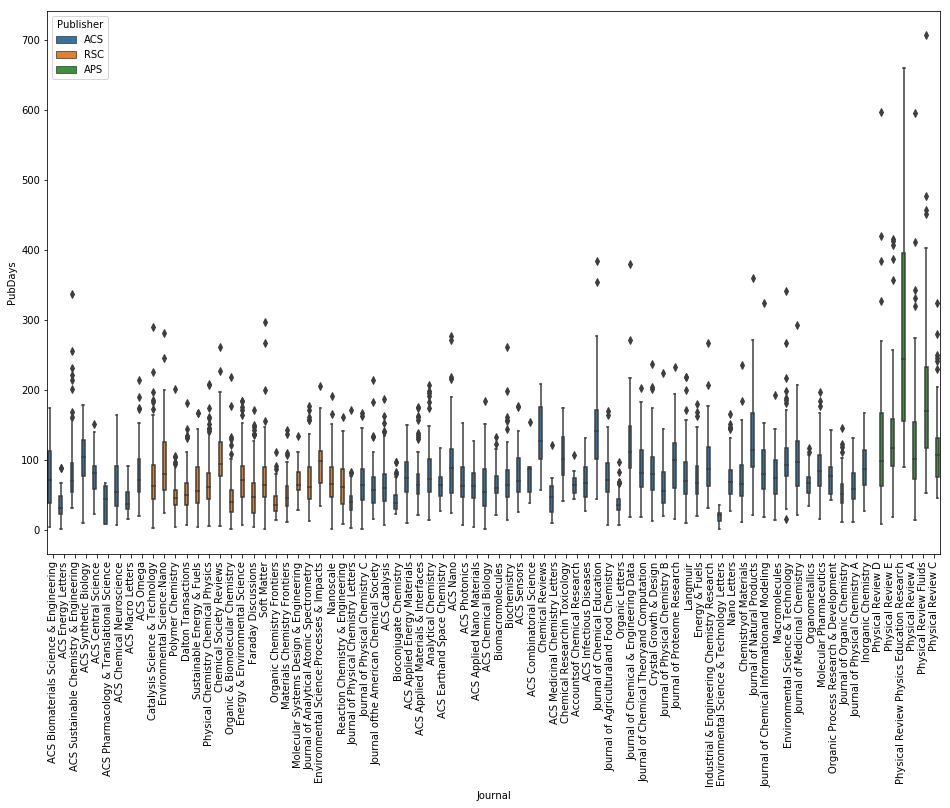

In [425]:
#Plotting
plt.figure(figsize=(16,10))
plt.clf()
#sns.swarmplot(x='Journal',y='PubDays',hue='Publisher',data=df,)
sns.boxplot(x='Journal',y='PubDays',hue='Publisher',data=df)
plt.xticks(rotation=90)

#### Wow!  
Looks like there are a <b>lot</b> of journals.  Let's get a closer look at journals that we have more than 50 data points for, so that the average date to publication we get is more statistical.

In [458]:
y = df.groupby('Journal')['Title'].count()
df_less = df[df['Journal'].apply(lambda x: y[x]>50)]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54]), <a list of 55 Text xticklabel objects>)

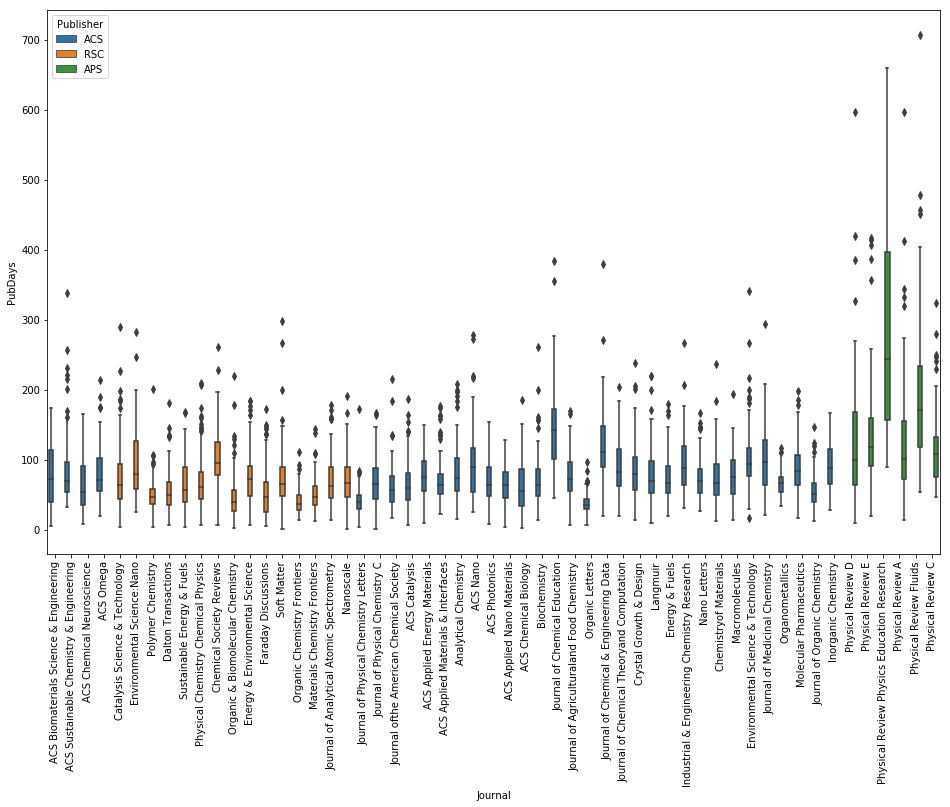

In [459]:
plt.figure(figsize=(16,10))
plt.clf()
#sns.swarmplot(x='Journal',y='PubDays',hue='Publisher',data=df_less,)
sns.boxplot(x='Journal',y='PubDays',hue='Publisher',data=df_less)
plt.xticks(rotation=90)

### Some observations...
It looks like the differences between time to publication among journals is not that significant; perhaps journals published by APS take slightly longer than those published by ACS and RSC.  Additionally, we see that ChemicalSocietyReviews has one of the higher averages out of the ASC and RSC journals, which makes sense since reviews tend to be more detailed than the average article.  The two journals that are Letters also seem to have shorter days to publication (as we would hope), but not by much.  


## Machine Learning
### Data cleaning
Now that we have a better feel for the data, let's see if we can predict the average days to publication of a journal based on some basic predictors.  Some obvious ones we just mentioned: it may be useful to know whether the journal is a letter or a review, and who the publisher was.  Another possibility that comes to my mind, is whether the journal's impact factor is at all correlated with publication time.  We might expect it to be a longer process to get an article accepted to a prestigious journal.  Given that idea, we'll join some impact factor data from Thomson Reuters with our dataframe

First, let's filter out journals with less than 15 articles to get a decent idea of the mean PubDays.  Then, let's boil down our dataframe to get rid of individual articles and include only average PubDays with the journals as keys.

In [471]:
y = df.groupby('Journal')['Title'].count()
df_s = df[df['Journal'].apply(lambda x: y[x]>15)]

#Get the average num pubdays per journal, retaining publisher
avg_pd = df_s.groupby('Journal').agg({'PubDays':'mean', 'Publisher':'first'})
avg_pd = avg_pd.reset_index()

#To avoid any case matching issues on the join we plan to do, let's make all journal titles lower case
avg_pd['Journal']=avg_pd['Journal'].str.lower()

Now let's go ahead and read in some journal impact data from Thomson Reuters, removing any "Not available" entries

In [472]:
ifs = pd.read_csv('journalimpactfactors2017.csv')
ifs['Journal'] = ifs['Journal'].str.lower()
ifs = ifs[ifs['Journal Impact Factor']!='Not Available']

Next we'll do an inner join on dataframes `avg_pd` and `ifs` using `Journal` as the key yielding a new dataframe, `jdf`.

In [473]:
jdf = avg_pd.join(ifs.set_index('Journal'),how='inner',on='Journal')
jdf.drop_duplicates(inplace=True)

### Extracting more predictors
As we noted before, it seemed like certain journal title key words might be useful in predicting the days to publication.  Here, we create additional machine-readable columns that denote whether a journal is educational, a letter, or a review.  We also separate the publisher column to be machine-readable, and remove thousand-separating commas from `Total Cites`.

In [474]:
jdf['Education']=jdf['Journal'].apply(lambda x: (int('educ' in x)))
jdf['Letter']=jdf['Journal'].apply(lambda x: (int('letter' in x)))
jdf['Review']=jdf['Journal'].apply(lambda x: (int('reviews' in x)))

publisher = pd.get_dummies(jdf['Publisher'],drop_first=True)
jdf = pd.concat([jdf,publisher],axis=1)
jdf.drop('Publisher',axis=1,inplace=True)
jdf['Total Cites']=jdf['Total Cites'].apply(lambda x: int(x.replace(',', '')))

### Training a model
Ok! Now we are ready to train a basic linear regression model.  We start by specifying a dataframe of predictors and a separate dataframe of the corresponding responses.

In [475]:
X = jdf.drop(['Journal','PubDays'],axis=1)
y = jdf['PubDays']

We import the linear regression model from sklearn, fit it to X and y, and make some predictions.  We plot the predicted PubDays versus the real values in a parity plot.

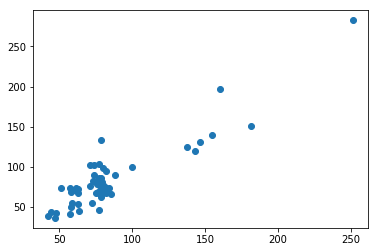

In [517]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(X,y)
predictions = lm.predict(X)
plt.scatter(predictions,y)

Not bad! Of course, this is an analysis of the training error, so we could be overfitting.  We are limited by only having ~60 data points to train on, but let's try to split our data into a training and testing set anyways to get a test error.

In [512]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

Refitting the model...

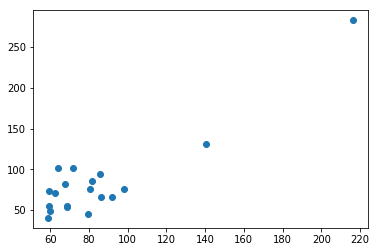

In [513]:
lm.fit(X_train,y_train)
predictions = lm.predict(X_test)
plt.scatter(predictions,y_test)

Still not too bad.  Of course, it would be helpful to have more data, and we can see that if the two high leverage points were not included in our test data our predictions might not look so great.  We can check out the mean absolute error, the root mean squared error, and the R^2 score to get a more quantitative feel for how well the model did.

In [514]:
from sklearn import metrics
print "MAE: ", metrics.mean_absolute_error(y_test,predictions)
print "RMSE: ", np.sqrt(metrics.mean_squared_error(y_test,predictions))
print "R2: ", metrics.r2_score(y_test,predictions)

MAE:  19.13299081866193
RMSE:  24.128228260425736
R2:  0.7817758298901024


The MAE and RMSE are good measures of what sort of prediction error we might expect if deploying this model in the real world.  They suggest we should be able to predict a journal's average days to publication with an average error of +/- 20-25 days, which is not bad considering the scale of our data is 250 days.  The R^2 also suggests that the model does well to account for the spread in the data, but if the two high leverage points at ~250 days and ~150 days were removed, we would have a much lower R^2 value.  Additionally, the shape of the data in the parity plots seems to suggest a linear model was a decent approximation.

Now let's see which descriptors the model found most useful in predicting the data.

In [518]:
pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])

,Coefficient
Rank,0.006472
Total Cites,-0.000098
Journal Impact Factor,1.027155
Eigenfactor Score,57.896743
Education,78.132410
Letter,-32.812382
Review,8.505212
APS,61.559091
RSC,-19.486617


`Rank` and `Total Cites` are ~0, which we might expect. `Rank` is a metric generated by Thomson Reuters, not an established metric of journal prestige, and total cites probably has more to do with how long the journal has been around for.  `Journal Impact Factor` and `Eigenfactor Score`, both well-known metrics indicating journal prestige, are positively correlated with the average number of days an article takes to get published.  Additionally, journals researching `Education` and `Reviews` are correlated with higher days to publication, whereas the classification of a journal as a `Letter` means it tends to have fewer days to publication.  Finally, `APS` journals tend to have slower turnaround times than `ACS`, and `RSC` is slightly faster than `ACS`.